<a href="https://colab.research.google.com/github/diialex/portfolio.me/blob/main/Copy_of_GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks (GANs) on MNIST

In this notebook, we will explore **Generative Adversarial Networks (GANs)** — one of the most famous frameworks for **generative AI** before diffusion models became dominant.  

GANs work by setting up a competition between two neural networks:  
- a **Generator** that tries to create fake images (handwritten digits), and  
- a **Discriminator** that tries to distinguish real digits from fake ones.  

Through this *adversarial game*, both networks improve, and over time the generator learns how to produce digits that look increasingly realistic.  

In this session, we’ll:  
1. Load the **MNIST dataset** of handwritten digits.  
2. Define a simple **Generator** and **Discriminator**.  
3. Train them together in a GAN setup.  
4. Visualize the fake digits produced at different stages of training.  

The goal is not to get perfect results, but to **see the process of learning unfold** and understand the core idea of adversarial learning.

### What is MNIST?  
For this demo we’ll use **MNIST**, one of the most famous datasets in machine learning: https://www.kaggle.com/datasets/hojjatk/mnist-dataset

- **MNIST** = *Modified National Institute of Standards and Technology dataset*.  
- It contains **70,000 images** of handwritten digits (0–9).  
- Each image is small: **28 × 28 pixels**, grayscale.  
- Widely used as a **“Hello World” dataset** for testing machine learning and deep learning models (also used in the original GAN paper by Goodfellow in 2014)

Why MNIST for GANs?  
- The images are **simple** enough to train quickly (even on a laptop or Colab Notebook).  
- They are **complex** enough to show interesting patterns (people’s different handwriting styles).  
- Perfect for demonstrating how a model can **learn to generate new, realistic digits** from scratch.  

In this notebook, we will even **downsample the digits to 14×14 pixels** to make training easier and faster while still keeping them recognizable.


## Using a GPU

Training deep learning models like GANs can be computationally intensive. Using a **Graphics Processing Unit (GPU)** can significantly speed up the training process compared to running on a CPU. Google Colab provides free access to GPUs, which we recommend using for this notebook.

To ensure you are using a GPU runtime, go to the "Runtime" menu -> "Change runtime type" and select "GPU" as the hardware accelerator.

The following code snippet checks if a GPU is available and configured for TensorFlow:

In [ ]:
import tensorflow as tf

gpu_available = len(tf.config.list_physical_devices('GPU')) > 0
print(f"GPU Available: {gpu_available}")

if not gpu_available:
    print("Warning: No GPU available. Training will be significantly slower on a CPU.")

GPU Available: True


## Step 1: Load and Visualize the MNIST Dataset

Loaded 10000 training images with shape (10000, 14, 14).


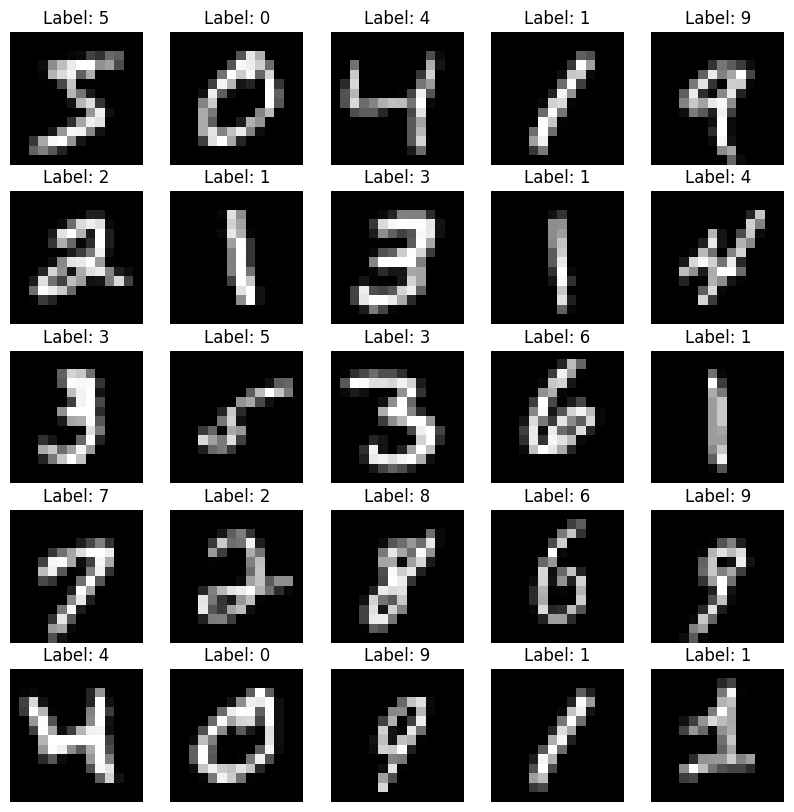

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Load the MNIST dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize the images to the range [0, 1]
train_images = train_images.astype('float32') / 255.

# Select a subset of the data (e.g., the first 10000 images)
num_samples = 10000
train_images = train_images[:num_samples]
train_labels = train_labels[:num_samples]

# Downsample the images to 14x14
train_images = tf.image.resize(train_images[..., tf.newaxis], (14, 14)).numpy()
train_images = train_images.squeeze() # Remove the channel dimension

print(f"Loaded {len(train_images)} training images with shape {train_images.shape}.")

# Display some examples
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
plt.show()

## Step 2: Prepare the Data for Training

GANs typically expect inputs in the range [-1, 1].  
We will normalize MNIST images accordingly and set up a TensorFlow dataset for batching.

In [ ]:
BUFFER_SIZE = len(train_images)
BATCH_SIZE = 128

# Normalize to [-1, 1]
train_images = (train_images - 0.5) * 2.0
train_images = train_images[..., tf.newaxis]

# Create TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Step 3: Build the Generator and Discriminator

- **Generator**: takes random noise as input and outputs a 14×14 image.  
- **Discriminator**: takes an image and outputs a probability (real or fake).  

In [ ]:
from tensorflow.keras import layers

LATENT_DIM = 64
IMG_H, IMG_W, IMG_C = 14, 14, 1
USE_CONV = True  # ← toggle: True = DCGAN-style; False = simple MLP

def build_generator_mlp():
    return tf.keras.Sequential([
        layers.Input(shape=(LATENT_DIM,)),
        layers.Dense(128), layers.LeakyReLU(0.2),
        layers.Dense(IMG_H*IMG_W, activation="tanh"),
        layers.Reshape((IMG_H, IMG_W, IMG_C)),
    ], name="G_MLP")

def build_discriminator_mlp():
    return tf.keras.Sequential([
        layers.Input(shape=(IMG_H, IMG_W, IMG_C)),
        layers.Flatten(),
        layers.Dense(128), layers.LeakyReLU(0.2),
        layers.Dense(1, activation="sigmoid"),
    ], name="D_MLP")

def build_generator_conv():
    # z → 7x7x16 → upsample to 14x14x1
    return tf.keras.Sequential([
        layers.Input(shape=(LATENT_DIM,)),
        layers.Dense(7*7*16),
        layers.LeakyReLU(0.2),
        layers.Reshape((7, 7, 16)),
        layers.Conv2DTranspose(16, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2D(1, kernel_size=3, padding="same", activation="tanh"),
    ], name="G_Conv")

def build_discriminator_conv():
    return tf.keras.Sequential([
        layers.Input(shape=(IMG_H, IMG_W, IMG_C)),
        layers.Conv2D(32, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2D(64, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid"),
    ], name="D_Conv")

generator = build_generator_conv() if USE_CONV else build_generator_mlp()
discriminator = build_discriminator_conv() if USE_CONV else build_discriminator_mlp()

generator.summary(); discriminator.summary()

Model: "G_Conv"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 784)            │        50,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 16)     │         4,112 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,217 (215.69 KB)

 Trainable params: 55,217 (215.69 KB)

 Non-trainable params: 0 (0.00 B)

Model: "D_Conv"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 32)       │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,841 (77.50 KB)

 Trainable params: 19,841 (77.50 KB)

 Non-trainable params: 0 (0.00 B)

## Step 4: Define the Loss Functions and Optimizers

- Discriminator is trained with **binary crossentropy** to classify real vs. fake.  
- Generator is trained to **fool the discriminator** into thinking its outputs are real.  


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return (real_loss + fake_loss) / 2

# The generator is trying to make the discriminator output 1 (indicating "real") for the fake images
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


## Step 5: Training Step

For each batch:
1. Sample random noise, generate fake images.  
2. Train the discriminator on real + fake images.  
3. Train the generator (via how well it fools the discriminator).  


In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


## Step 6: Training Loop

We’ll train for a few epochs and visualize generated samples after each one.  


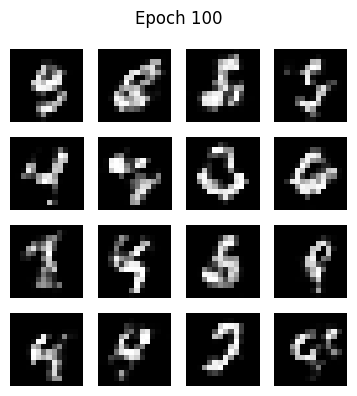

Epoch 1, Generator loss: 0.5643, Discriminator loss: 0.5277, Discriminator Accuracy: 0.4782
Time for epoch 1 is 7.84 sec
Epoch 2, Generator loss: 0.7917, Discriminator loss: 0.4400, Discriminator Accuracy: 0.7292
Time for epoch 2 is 2.15 sec
Epoch 3, Generator loss: 0.8556, Discriminator loss: 0.3345, Discriminator Accuracy: 0.9653
Time for epoch 3 is 2.63 sec
Epoch 4, Generator loss: 0.8406, Discriminator loss: 0.3698, Discriminator Accuracy: 0.9674
Time for epoch 4 is 2.09 sec
Epoch 5, Generator loss: 1.2377, Discriminator loss: 0.2536, Discriminator Accuracy: 0.9936
Time for epoch 5 is 2.07 sec
Epoch 6, Generator loss: 1.2461, Discriminator loss: 0.2717, Discriminator Accuracy: 0.9869
Time for epoch 6 is 2.06 sec
Epoch 7, Generator loss: 1.2929, Discriminator loss: 0.2693, Discriminator Accuracy: 0.9856
Time for epoch 7 is 2.12 sec
Epoch 8, Generator loss: 1.0287, Discriminator loss: 0.4345, Discriminator Accuracy: 0.8794
Time for epoch 8 is 3.12 sec
Epoch 9, Generator loss: 1.2529,

In [ ]:
import time
from IPython.display import display, clear_output

EPOCHS = 100
seed = tf.random.normal([16, LATENT_DIM])  # fixed seed for consistent samples
discriminator_accuracies = [] # List to store discriminator accuracies

# Setup the figure for in-place plotting
fig = plt.figure(figsize=(4,4))
handle = display(fig, display_id=True) # Get a handle to the display

def generate_and_plot(model, epoch, test_input, handle):
    predictions = model(test_input, training=False)
    predictions = (predictions + 1) / 2.0  # back to [0,1]

    # Clear previous plots in the figure
    for ax in fig.get_axes():
        ax.cla()

    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i,:,:,0], cmap='gray')
        plt.axis('off')
    fig.suptitle(f"Epoch {epoch}")
    plt.tight_layout()
    handle.update(fig) # Update the displayed figure
    # plt.pause(0.1) # Pause might not be needed with handle.update

for epoch in range(1, EPOCHS+1):
    start = time.time()
    total_real_correct = 0
    total_fake_correct = 0
    total_samples = 0

    for image_batch in train_dataset:
        g_loss, d_loss = train_step(image_batch)

        # Calculate discriminator accuracy for the current batch
        real_output = discriminator(image_batch, training=False)
        fake_output = discriminator(generator(tf.random.normal([BATCH_SIZE, LATENT_DIM]), training=False), training=False)

        real_correct = tf.reduce_sum(tf.cast(real_output > 0.5, tf.float32))
        fake_correct = tf.reduce_sum(tf.cast(fake_output < 0.5, tf.float32))

        total_real_correct += real_correct.numpy()
        total_fake_correct += fake_correct.numpy()
        total_samples += BATCH_SIZE * 2 # Real and fake samples in each batch

    epoch_discriminator_accuracy = (total_real_correct + total_fake_correct) / total_samples
    discriminator_accuracies.append(epoch_discriminator_accuracy)

    print(f"Epoch {epoch}, Generator loss: {g_loss:.4f}, Discriminator loss: {d_loss:.4f}, Discriminator Accuracy: {epoch_discriminator_accuracy:.4f}")
    generate_and_plot(generator, epoch, seed, handle) # Pass the handle to the plotting function
    print (f"Time for epoch {epoch} is {time.time()-start:.2f} sec")

plt.close(fig) # Close the figure after training

## Step 7: Exploring the Latent Space

The generator doesn’t just spit out random noise — it maps points from a **latent space** into images.  
Each random vector (`z`) can be thought of as a **set of hidden dials** that control digit style (thickness, roundness, etc.).  

By **interpolating** between 4 random vectors, we can see how digits *morph* smoothly, showing that the generator has learned a structured, meaningful space.  


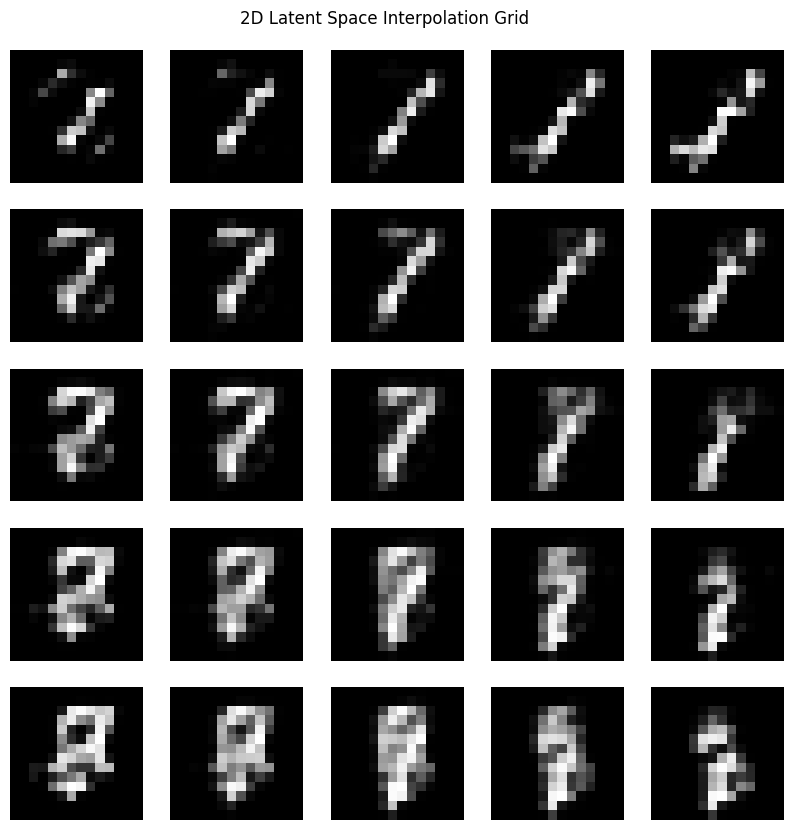

In [ ]:
def interpolate_2d(z_tl, z_tr, z_bl, z_br, grid_size=5):
    """
    Interpolates a 2D grid between 4 corner latent vectors.
    z_tl = top-left, z_tr = top-right, z_bl = bottom-left, z_br = bottom-right
    """
    alphas = np.linspace(0, 1, grid_size)
    betas = np.linspace(0, 1, grid_size)
    grid = []
    for a in alphas:  # vertical interpolation
        row = []
        for b in betas:  # horizontal interpolation
            top = (1 - b) * z_tl + b * z_tr
            bottom = (1 - b) * z_bl + b * z_br
            z = (1 - a) * top + a * bottom
            row.append(z)
        grid.append(row)
    return np.array(grid)

# Pick four random latent vectors
z_tl = tf.random.normal([LATENT_DIM])
z_tr = tf.random.normal([LATENT_DIM])
z_bl = tf.random.normal([LATENT_DIM])
z_br = tf.random.normal([LATENT_DIM])

# Build grid in latent space
grid_size = 5
z_grid = interpolate_2d(z_tl, z_tr, z_bl, z_br, grid_size=grid_size)

# Generate images
generated_grid = []
for i in range(grid_size):
    row_imgs = []
    for j in range(grid_size):
        z = tf.expand_dims(z_grid[i, j], 0)  # shape (1, LATENT_DIM)
        img = generator(z, training=False)[0, :, :, 0]
        img = (img + 1) / 2.0
        row_imgs.append(img)
    generated_grid.append(row_imgs)

# Plot grid
plt.figure(figsize=(10, 10))
for i in range(grid_size):
    for j in range(grid_size):
        plt.subplot(grid_size, grid_size, i*grid_size + j + 1)
        plt.imshow(generated_grid[i][j], cmap='gray')
        plt.axis('off')
plt.suptitle("2D Latent Space Interpolation Grid", y=0.92)
plt.show()

